<a href="https://colab.research.google.com/github/Sergey-Tkachenko/MachineLearningSeminars/blob/master/hometask/task1-1/hometask_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/Sergey-Tkachenko/MachineLearningSeminars/master/hometask/task1-1/requirements.txt
    !pip install -q -r requirements.txt

     |████████████████████████████████| 10.5 MB 27.1 MB/s 
     |████████████████████████████████| 14.5 MB 33 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, train_test_split, ParameterGrid, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Данные
## Начало работы с данными
Начнем с загрузки датасета.

In [17]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.shape, y.shape

((569, 30), (569,))

In [18]:
X.sample(5)

mean radius  mean texture  ...  worst symmetry  worst fractal dimension
487        19.44         18.82  ...          0.3266                  0.09009
482        13.47         14.06  ...          0.3227                  0.09326
105        13.11         15.56  ...          0.3147                  0.14050
409        12.27         17.92  ...          0.3455                  0.06896
475        12.83         15.73  ...          0.3006                  0.07802

[5 rows x 30 columns]

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [20]:
y.unique()

array([0, 1])

Множество объектов:
- В данной выборке каждый объект описывается n = 30 признаками.
- Все признаки являются **вещественными**. 
- Количество объектов в выборке = 569.
- Мощность множетсва ответов = 2
- Тип задачи машинного обучения - бинарная классификация.

## Анализ данных

Так как признаков много, строить pairplot как в семинарах мы не будем, а начнем с более просто инструмента - boxplot'a. На нем отображается медиана, а также разброс значений в каждом признаке(0.25 и 0.75 квантили).

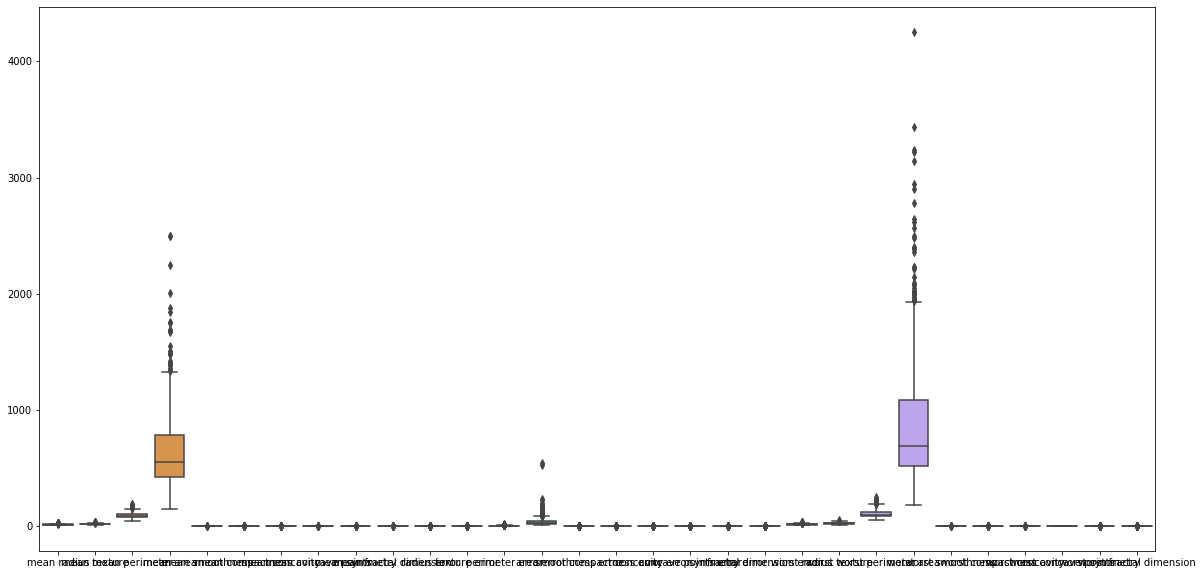

In [21]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=X)

Из boxplot'a можно сделать следующие выводы:
- в данных присутствуют выбросы, но не очень сильные
- данные распределены неравномерно, средние значения у всех могут существенно варьироваться

Перед тем, как перейти к более сложному анализу, построим ещё матрицу корреляций:

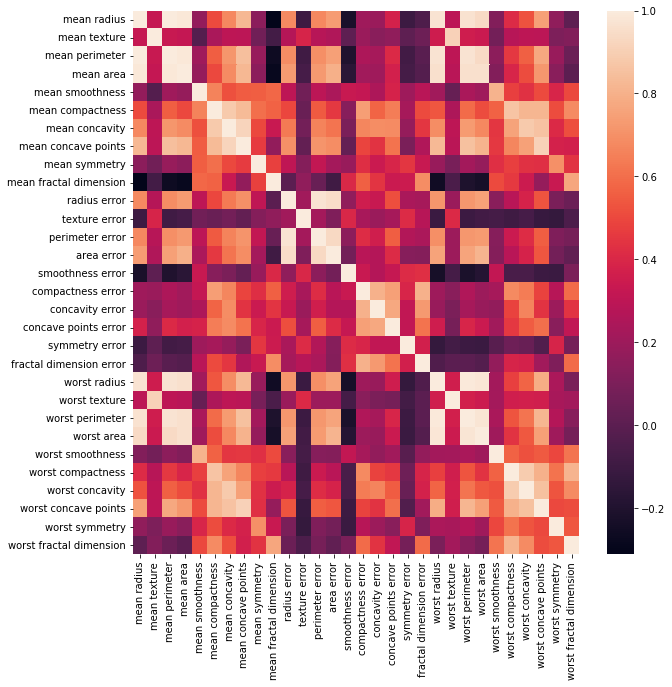

In [22]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr())

Из матрицы корреляций особенно выделяются 5 квадратов размера 4 х 4, которые соответсвуют следующим показателям:

1. mean radius
2. mean texture
3. mean perimeter
4. mean area

Все, кроме mean texture, сильно коррелируют между собой, а потому на квадратах присутствует характерный "крест". 
Остальные признаки имеют тренд на положительную корреляцию между собой, но не столь ярко выраженную.

Для упрощения дальнейшего анализа разобъем все признаки на три группы:
1. "mean" (0 - 9)
2. "error" (10 - 19)
3. "worst" (20 - 29)

In [23]:
mean_feats = X.columns[:10]
error_feats = X.columns[10:20]
worst_feats = X.columns[20:]

### Mean features

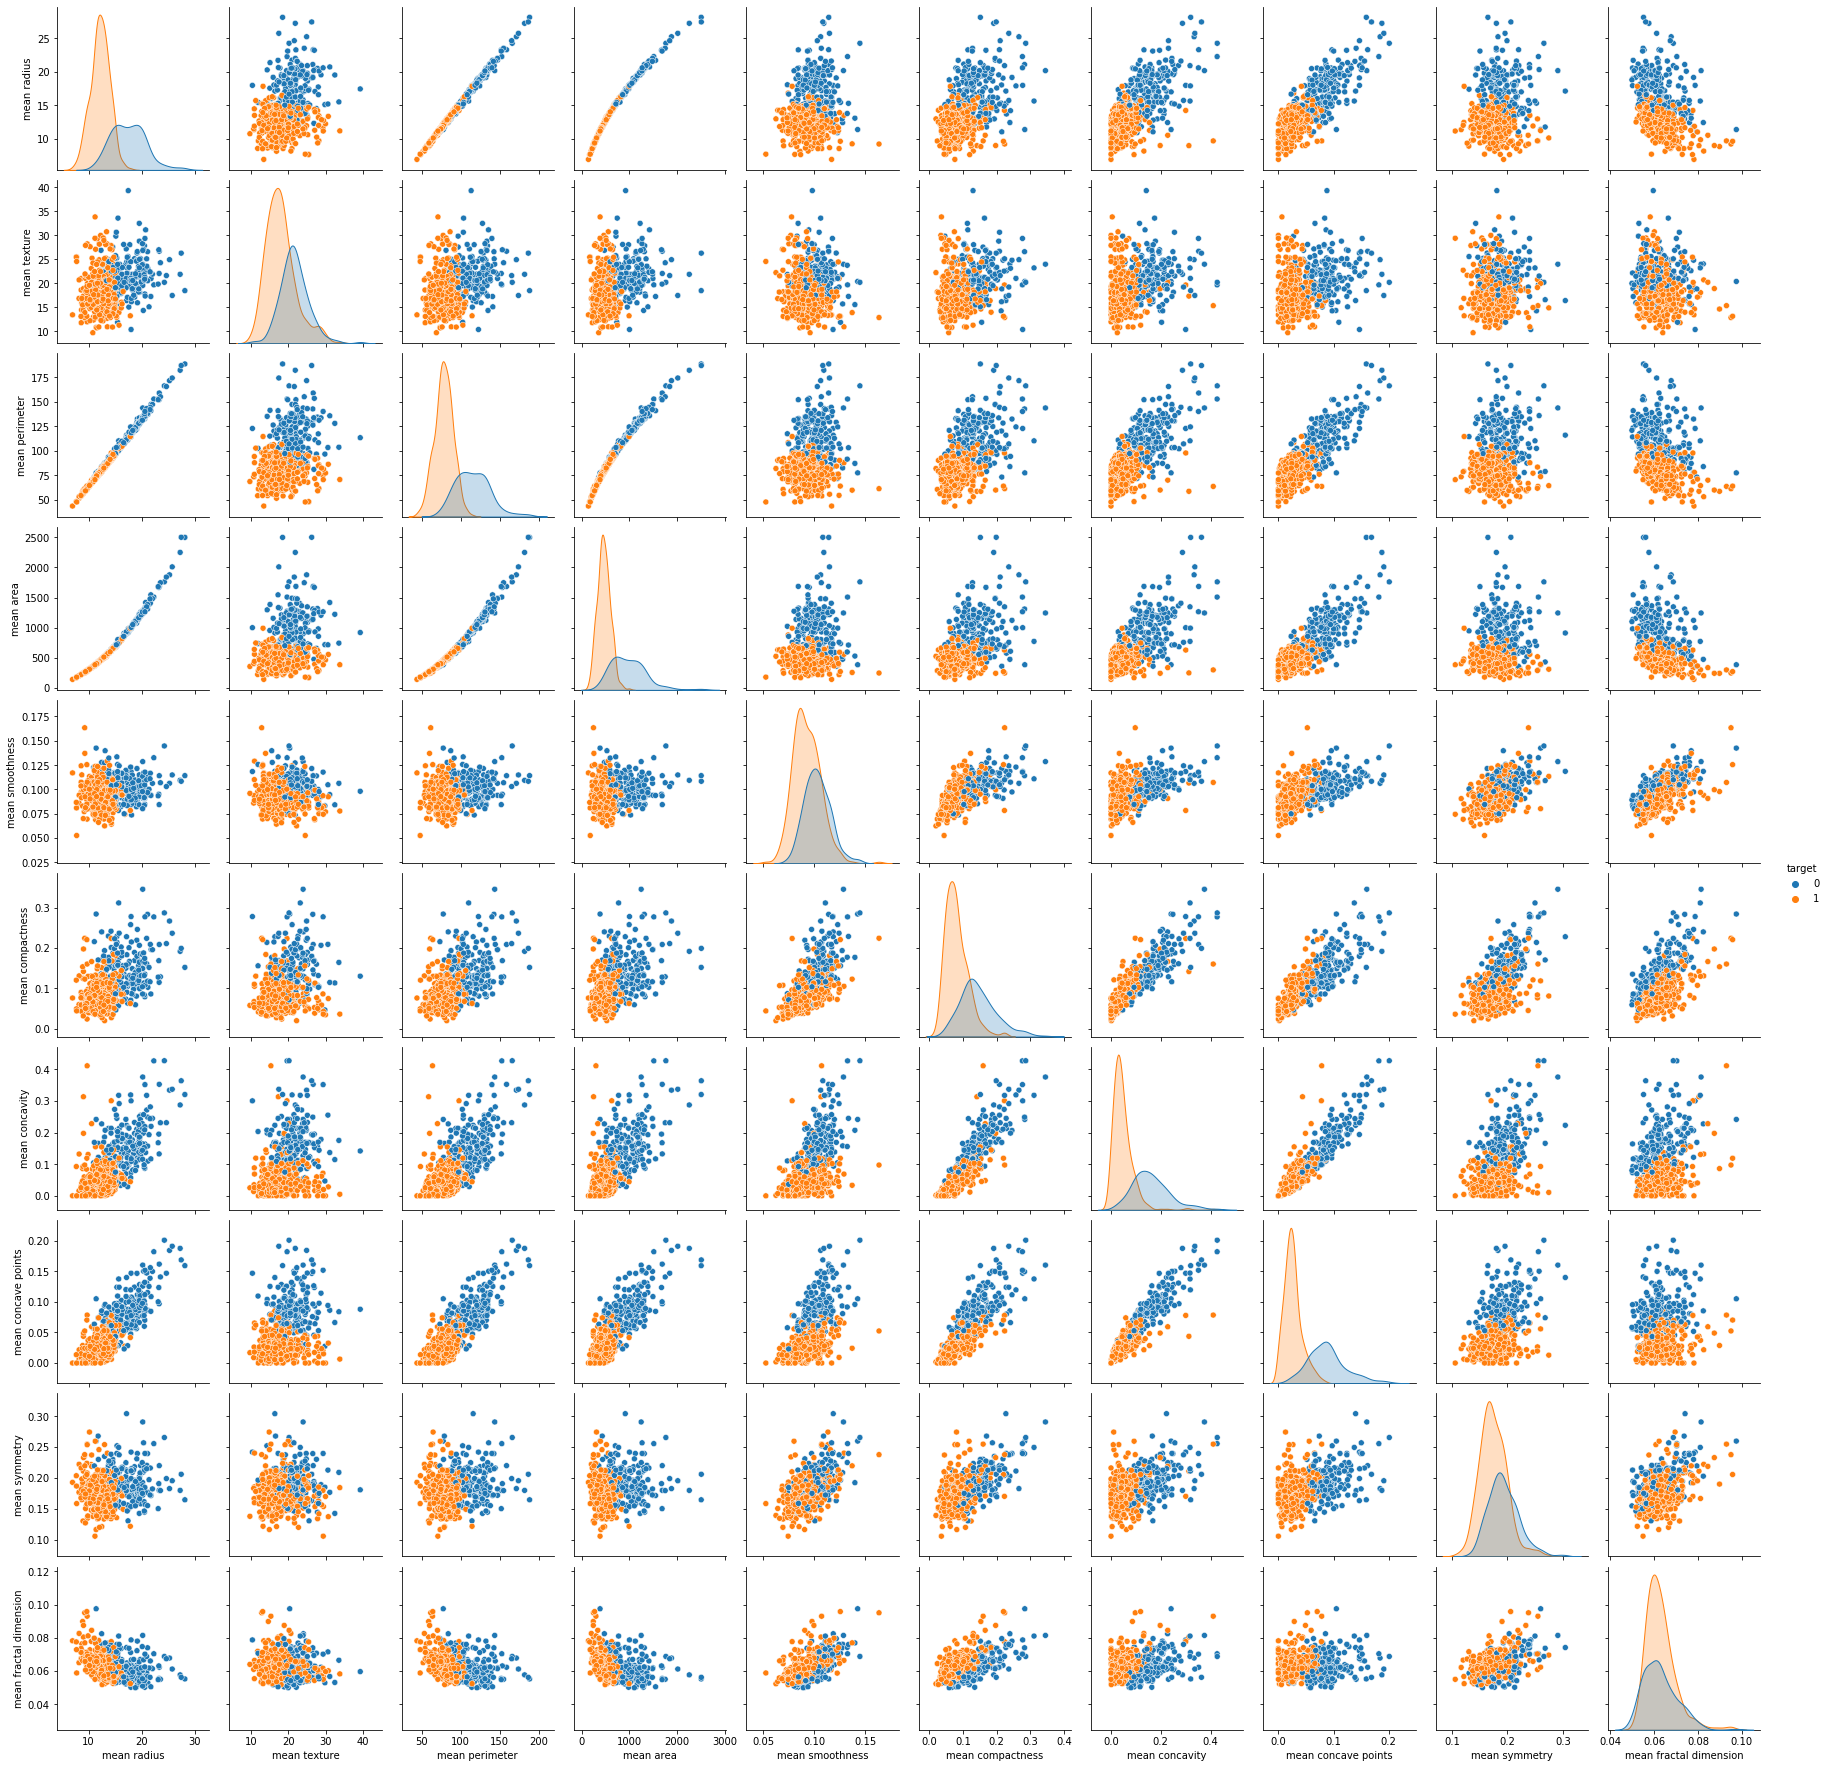

In [24]:
def show_pairplot(features_set):
    X_with_target = pd.concat([X[features_set], y], axis=1)
    sns.pairplot(X_with_target, hue='target')
    
    plt.show()

show_pairplot(mean_feats)

Из pairplot'a по mean features видно, что:
1. Классы неплохо отделяются друг от друга даже обычной линией - e.g. (radius, texture), (perimeter, smoothness).
2. По некоторым признакам распределение позволяет отделить один класс от другого - e.g. perimeter, concave points.

Далее построим подобные графики для оставшихся двух множеств признаков.

### Error features

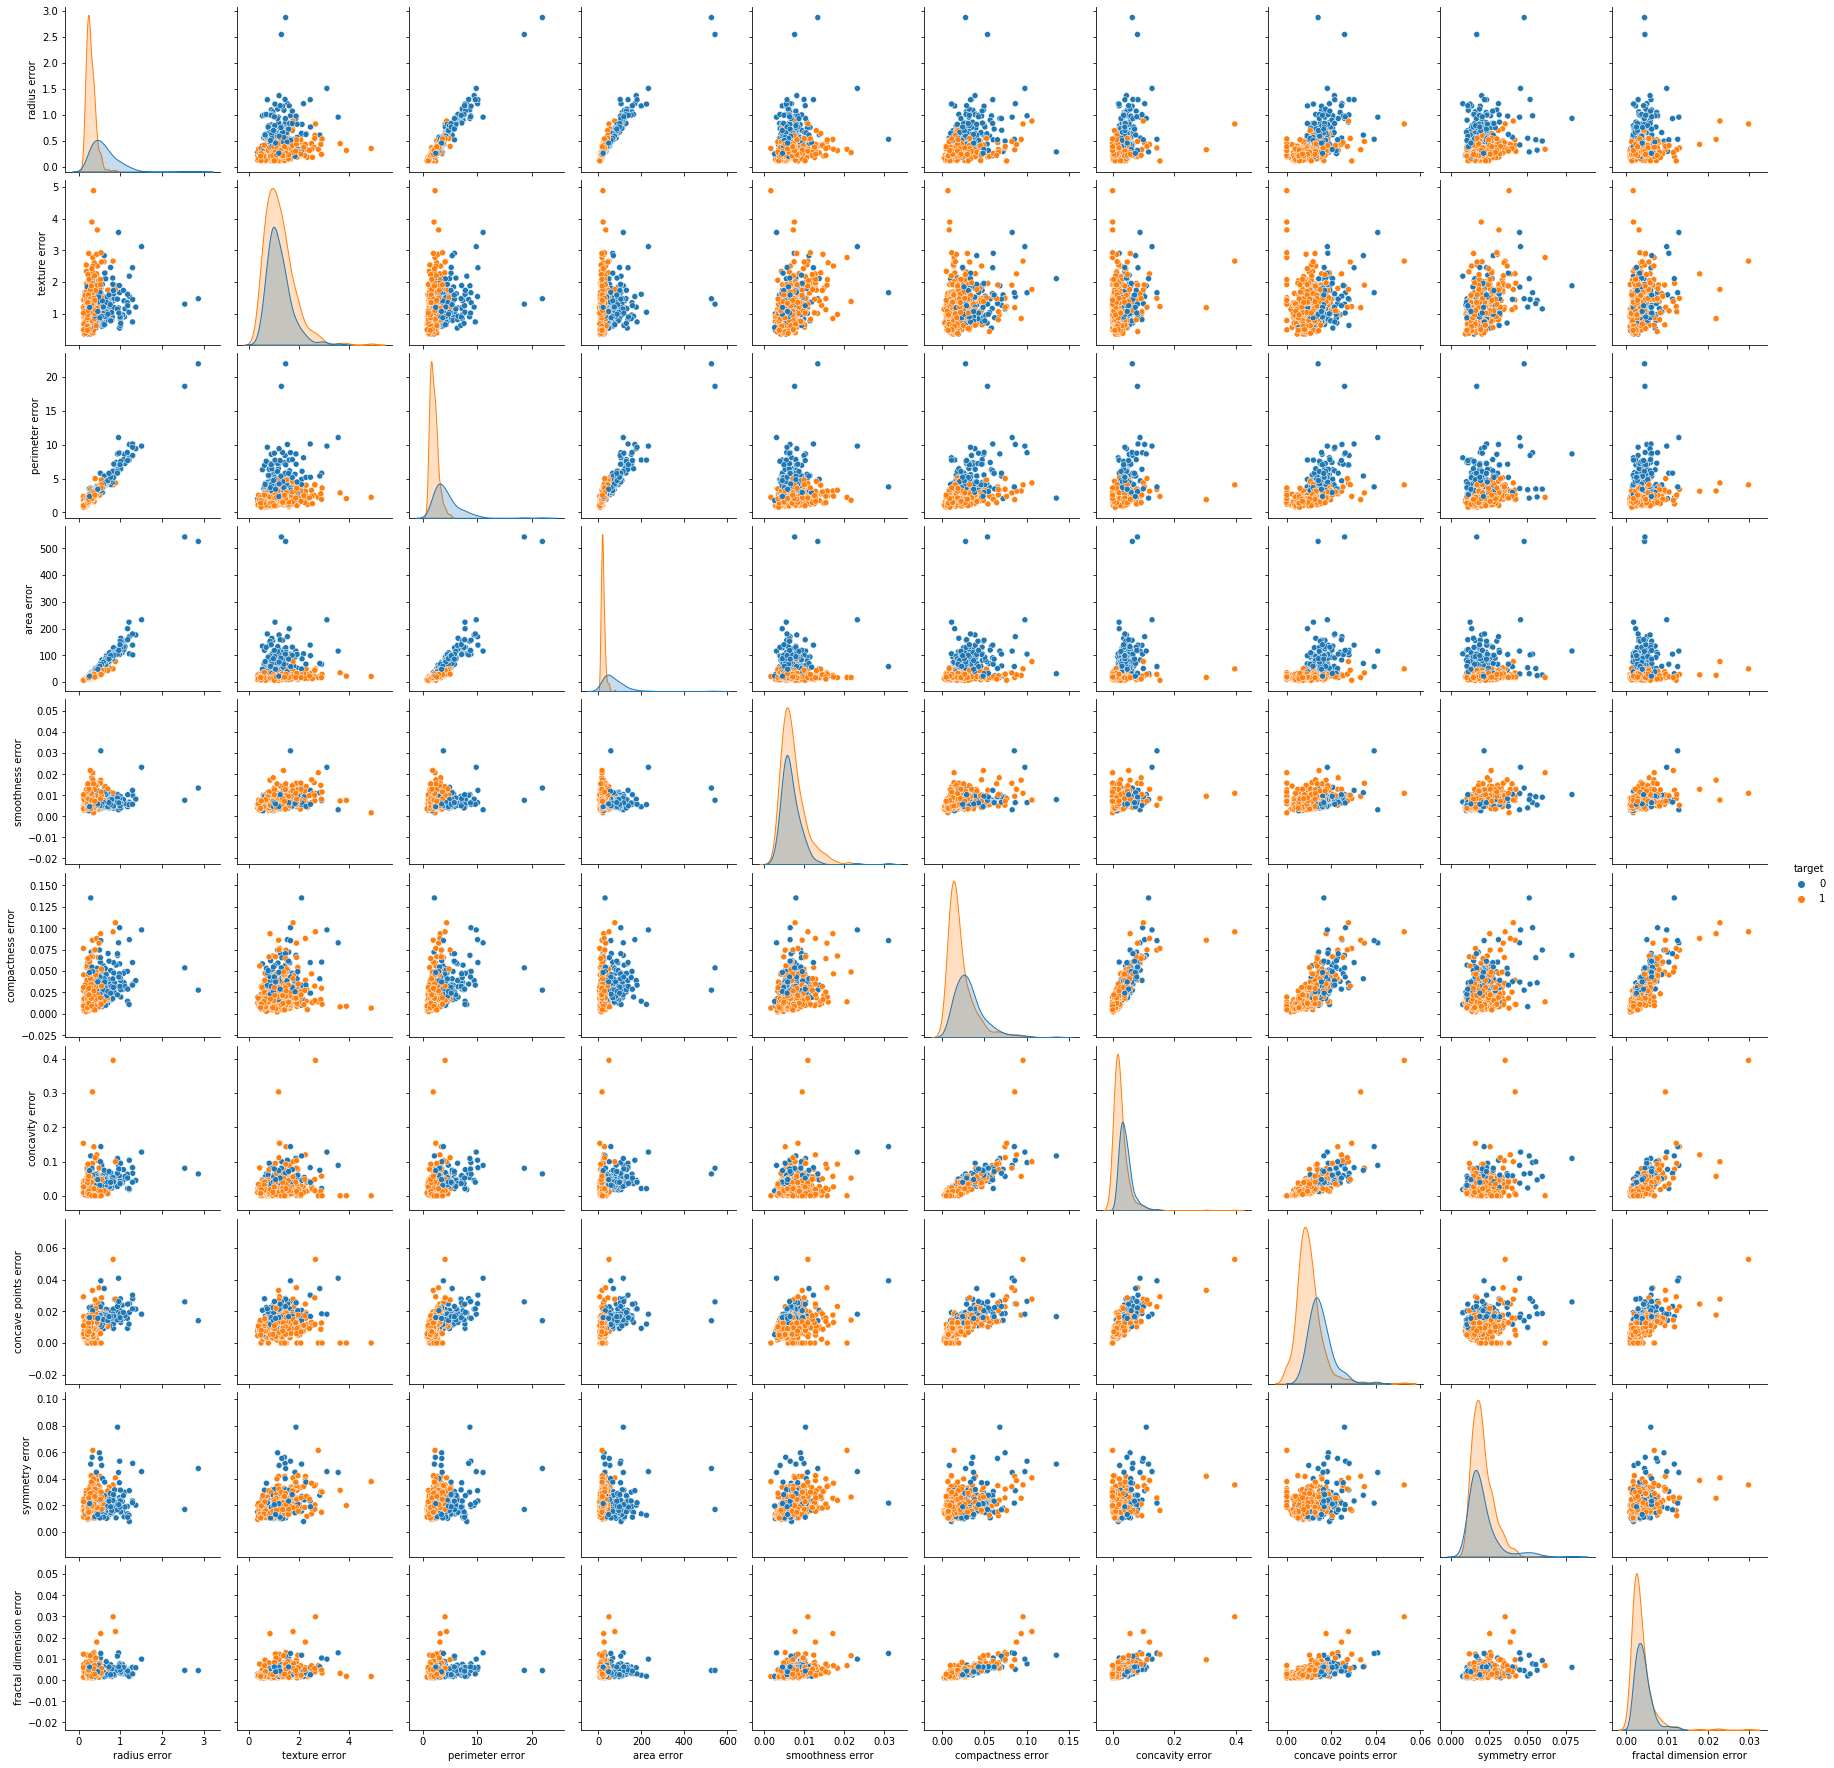

In [25]:
show_pairplot(error_feats)

Тут картина в целом хуже, но все ещё можно разделить классы по некоторым признакам(e.g. arrea).

### Worst features

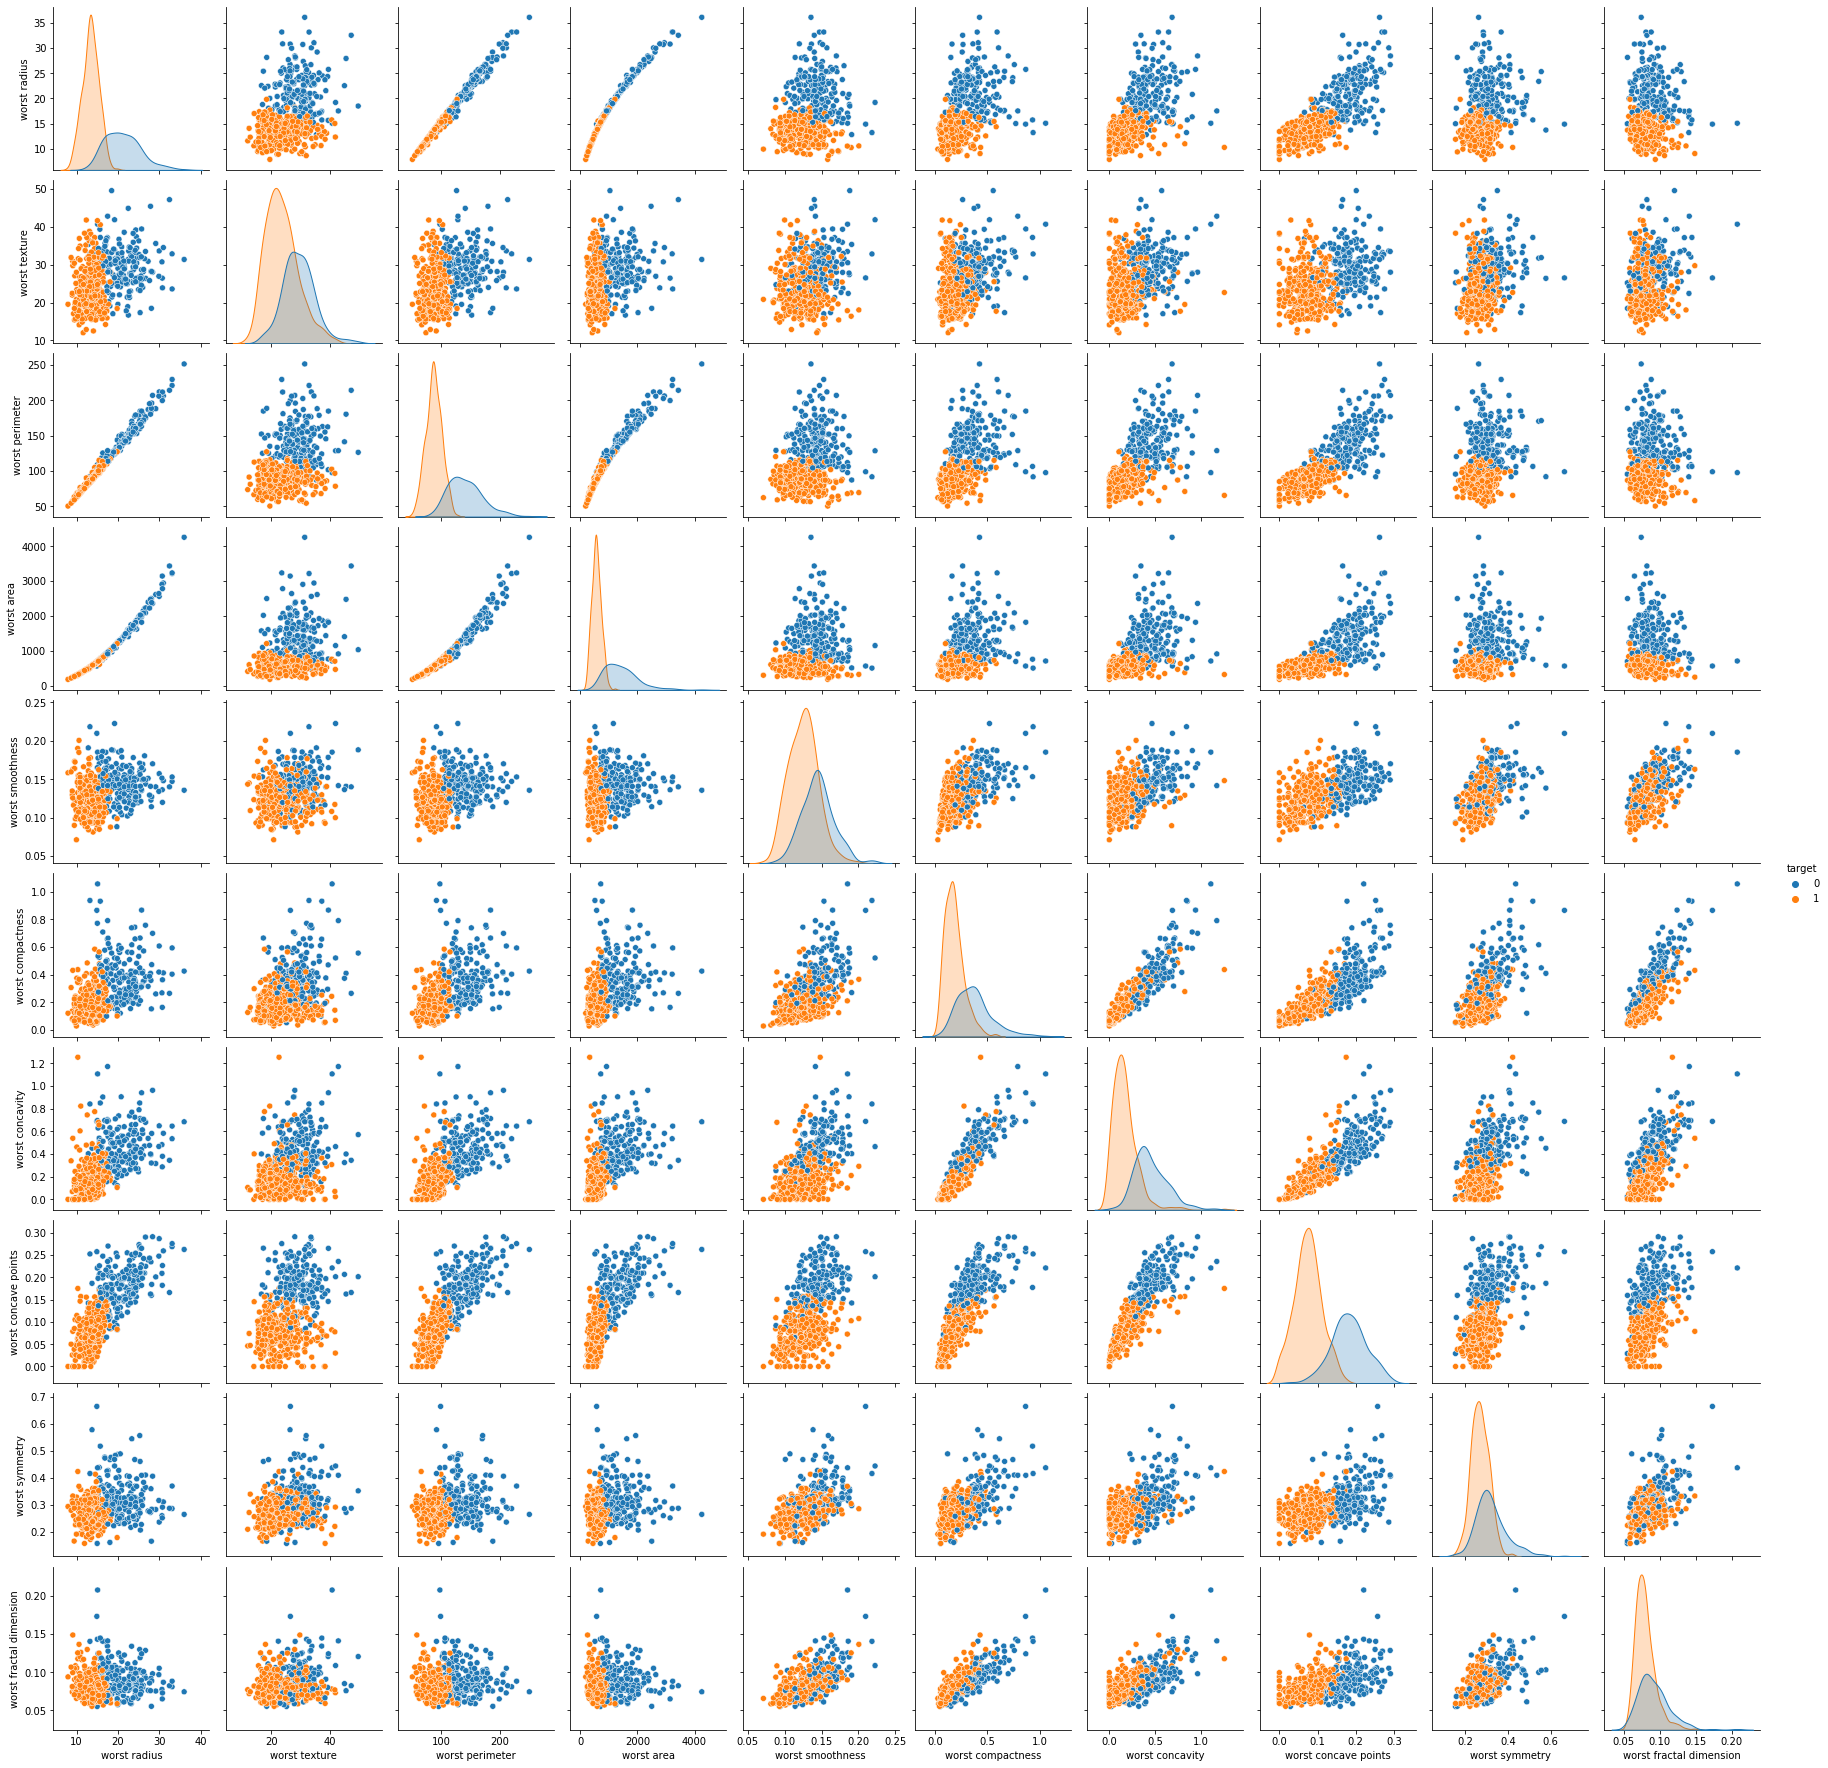

In [26]:
show_pairplot(worst_feats)

Тут картина схожа с mean features - по многим признакам можно уверенно отделить один класс от другого, e.g. concave points, perimeter.

# Построение моделей
Начнем с разбиения выборки на train/test.

In [27]:
# не нормируем данные сразу, сырые значение X_train нам нужны для кросс валидации
X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1, random_state=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((512, 30), (512,), (57, 30), (57,))

In [28]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test) # принципиально, чтобы значения нормировочных констант были из train

## Support Vector Machine Classifier
Начнем с единственного неметрического вектора классификации - SVM. Воспользуемя его реализацией из sklearn. По заданию нам необходимо:
1. Отнормировать данные
2. Подобрать гиперпараметры
3. Подобрать регуляризаторы (в данном случае только L2, поэтому будет подбирать вес при ней)

Подбирать оптимальные гиперпараметры мы будем по слудующей сетке:
- Ядра: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
- С: регуляризация, коэффициент при L2 метрике
- max_iter: если поставить заведомо малое значение tol(e.g. 1e-8), то будет соотсветсвовать количеству эпох.

### Baseline

In [29]:
baseline_svc = SVC(C=1.0, kernel='linear', tol=1e-8, max_iter=2000)

baseline_svc.fit(X_train_norm, Y_train)
print(classification_report(Y_test, baseline_svc.predict(X_test_norm)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.97      0.97      0.97        40

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



Как мы можем видеть, наши заключения в разделе "Анализ данных" оказались верны - выборка может быть решена с хорошей точностью обычным линейным классификатором.

### Подбор гиперпараметров SVM


In [30]:
svm_grid = ParameterGrid({
    "C": [1e-4, 1e-2, 1, 1e2, 1e4], # вот здесь и будет происходить подбор регуляризации
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'max_iter': [500, 2000, 5000]
})

Grid Search и функцию отрисовки результатов возьмем из семинаров(хороше получилась, почему бы и не использовать?).

In [31]:
def draw_table(data, title=['ACCURACY'], width=[60, 11]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

In [32]:
cross_val = KFold(5, shuffle=True)

scores = dict()
for item in tqdm(svm_grid):
    list_of_scores = []
    for train_index, test_index in cross_val.split(X_train):
        
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        
        # А вот здесь становится понятно, почему нельзя было сразу нормализовать всю выборку:
        # в случае kfold статистики из валидационного фолда попали бы в обучающую выборку, т.е. leakage
        
        scaler = StandardScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_test_fold = scaler.transform(x_test_fold)
        
        model = SVC(**item, tol=1e-8)
        model.fit(x_train_fold, y_train_fold)
        
        acc = accuracy_score(y_test_fold, model.predict(x_test_fold))
        
        
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]


In [33]:
draw_table(scores)

+------------------------------------------------------------+-----------+
|                                                            |   ACCURACY|
+------------------------------------------------------------+-----------+
|          {'C': 0.0001, 'kernel': 'linear', 'max_iter': 500}|       0.63|
+------------------------------------------------------------+-----------+
|         {'C': 0.0001, 'kernel': 'linear', 'max_iter': 2000}|       0.63|
+------------------------------------------------------------+-----------+
|         {'C': 0.0001, 'kernel': 'linear', 'max_iter': 5000}|       0.63|
+------------------------------------------------------------+-----------+
|            {'C': 0.0001, 'kernel': 'poly', 'max_iter': 500}|       0.62|
+------------------------------------------------------------+-----------+
|           {'C': 0.0001, 'kernel': 'poly', 'max_iter': 2000}|       0.62|
+------------------------------------------------------------+-----------+
|           {'C': 0.0001,

**Итоги кросс_валидации**:
1. Малая регуляризация (C = 0.0001) ведет к переобучению и, как следствие, существенному снижению качества.
2. Напротив, слишком большая регуляризация тоже снижает качество, но уже не так сильно.
3. max_iter не сильно влияет на результат - метод сходится быстро.
4. Хуже всех себя показывает полиномиальное ядро, лучше всех - линейное и rbf. При этом rbf показывает схожие результаты с линейным, но лишь при небольших значениях регуляризации.

Дополнительно проведем ещё одну кросс-валидацию для более точной подгонки гиперпараметров:

In [34]:
svm_grid_2 = ParameterGrid({
    "C": np.linspace(0.5, 10, 100), # вот здесь и будет происходить подбор регуляризации
    'kernel': ['rbf'],
    'max_iter': [500, 2000, 5000]
})

In [35]:
cross_val = KFold(5, shuffle=True)

scores = dict()
for item in tqdm(svm_grid_2):
    list_of_scores = []
    for train_index, test_index in cross_val.split(X_train):
        
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        
        # А вот здесь становится понятно, почему нельзя было сразу нормализовать всю выборку:
        # в случае kfold статистики из валидационного фолда попали бы в обучающую выборку, т.е. leakage
        
        scaler = StandardScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_test_fold = scaler.transform(x_test_fold)
        
        model = SVC(**item, tol=1e-8)
        model.fit(x_train_fold, y_train_fold)
        
        acc = accuracy_score(y_test_fold, model.predict(x_test_fold))
        
        
        list_of_scores.append(acc)
    scores[str(item)] = np.mean(list_of_scores)

### Итоговая модель

In [36]:
# Тут просто возьмем лучшие гиперпараметры, без анализа.
best_num = np.argmax(list(scores.values()))
best_params = list(scores.keys())[best_num]
best_params

"{'C': 9.712121212121211, 'kernel': 'rbf', 'max_iter': 2000}"

In [37]:
best_svm = SVC(C= 4.242424242424242, kernel= 'rbf', max_iter= 500, tol=1e-8)
best_svm.fit(X_train_norm, Y_train)

print(classification_report(Y_test, best_svm.predict(X_test_norm)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.98      1.00      0.99        40

    accuracy                           0.98        57
   macro avg       0.99      0.97      0.98        57
weighted avg       0.98      0.98      0.98        57



Итого, нам удалось неплохо повысить качество классификации по сравнению с baseline путем несложного подбора гиперпараметров.

## kNN

Этот простой по своей сути алгоритм требует подбора только одного гиперпараметра - k. Его проще всего подобрать по LOO. Поэтому опустим часть с baseline и сразу перейдем к отбору гиперпараметров.

### Подбор гиперпараметров kNN

In [38]:
knn_param_grid = ParameterGrid({
    'n_neighbors' : list(range(1, 200))
})

In [39]:
cross_val = LeaveOneOut()

scores = dict()
for item in tqdm(knn_param_grid):
    list_of_scores = []
    for train_index, test_index in cross_val.split(X_train):
        
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        
        # А вот здесь становится понятно, почему нельзя было сразу нормализовать всю выборку:
        # в случае kfold статистики из валидационного фолда попали бы в обучающую выборку, т.е. leakage
        
        scaler = StandardScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_test_fold = scaler.transform(x_test_fold)
        
        model = KNeighborsClassifier(**item)
        model.fit(x_train_fold, y_train_fold)
        
        acc = accuracy_score(y_test_fold, model.predict(x_test_fold))
        
        
        list_of_scores.append(acc)
    scores[str(item)] = np.mean(list_of_scores)

Рассмотрим зависимость точности предсказаний от числа k:

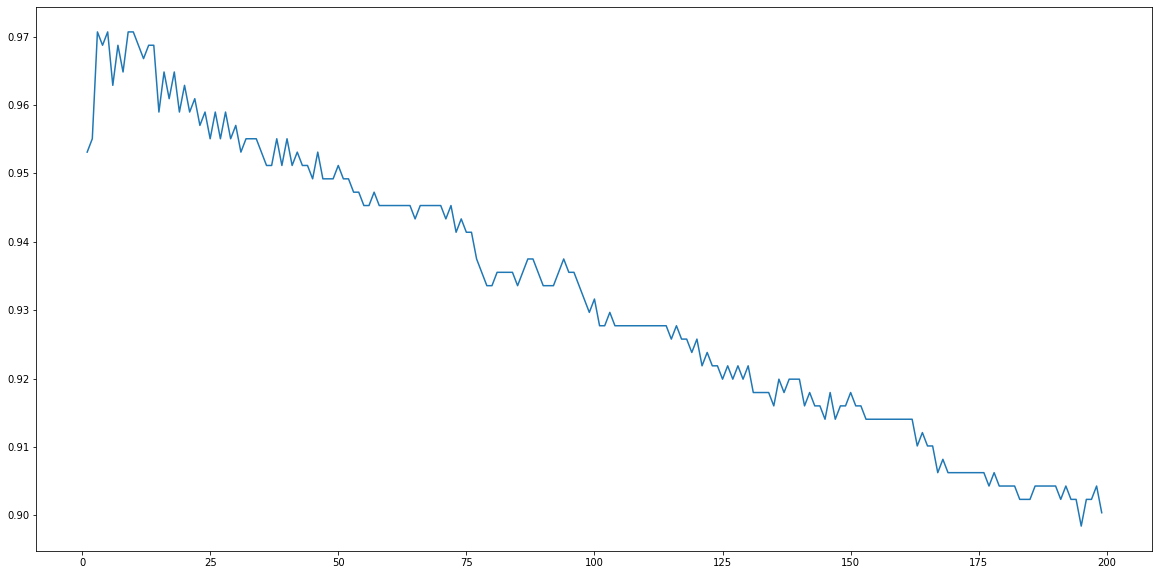

In [40]:
k_values = knn_param_grid.param_grid[0]['n_neighbors']
accuracy_values = list(scores.values())

plt.figure(figsize=(20, 10))
plt.plot(k_values, accuracy_values)

Видно, что сначала качество резко растет, а затем почти линейно начинает убывать. То есть для данной выборки оптимальные является значение в 1 - 20 соседей. 
Точное число определим простым argmax:

In [41]:
k_best = k_values[np.argmax(accuracy_values)]
k_best

3

### Итоговая модель

In [42]:
best_knn = KNeighborsClassifier(n_neighbors=k_best)
best_knn.fit(X_train_norm, Y_train)

print(classification_report(Y_test, best_knn.predict(X_test_norm)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.95      0.95      0.95        40

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57



Качество итогового классификатора несколько ниже, чем на кросс-валидации. Связано это обстоятельство с тем, что по большому счету классификатору все равно, какое k в промежутке от 3 до 20 брать. Действительно, если рассмотреть часть графика выше:

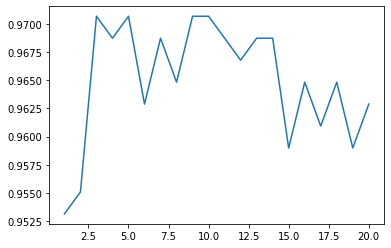

In [43]:
plt.plot(np.arange(1, 21), accuracy_values[:20])

Видно, что оптимальных с точки зрения k значений несколько. Если мы возьмем, например, значение 10:

In [44]:
nn10 = KNeighborsClassifier(n_neighbors=10)
nn10.fit(X_train_norm, Y_train)

print(classification_report(Y_test, nn10.predict(X_test_norm)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.97      0.95      0.96        40

    accuracy                           0.95        57
   macro avg       0.93      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



Видно, что качество несколько повышается. Однако это уже подгонка под тест, что недопустимо. Поэтому в дальнейшем мы будем аппелировать именно к модели с k равным 3.

## Potential Functions Method

Нам снова повезло: у нас бинарная классификация, так что можно использовать ту же функцию, что и в семинарах.

In [45]:
class PFM(object):
    def __init__(self, kernel=None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    def scores(self, X):
        features = self.gams*self.kernel(cdist(X, self.X)) # l_test x l_train
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1), # 
             np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1)]).T
        return scores
    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)
    def fit(self, X, Y, epoch=10):
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

Чтобы добавить хоть немного разнообразия, опишем разные ядра:

In [46]:
def rectangle(rel_dist):
    return (np.abs(rel_dist) <= 1)

def triangle(rel_dist):
    return (1 - np.abs(rel_dist)) * rectangle(rel_dist)

def quadratic(rel_dist): # вот это было в семинарах
    return (1 - rel_dist ** 2) * rectangle(rel_dist)

def quartic(rel_dist):
    return (1 - rel_dist ** 2) ** 2 * rectangle(rel_dist)

def gaussian(rel_dist):
    return np.exp(- rel_dist ** 2 / 2)

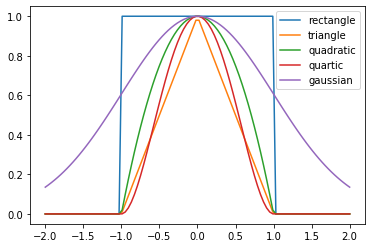

In [47]:
# Visualiztion
xs = np.linspace(-2, 2, 100)

windows = [rectangle, triangle, quadratic, quartic, gaussian]
names = ['rectangle', 'triangle', 'quadratic', 'quartic', 'gaussian']
for win, name in zip(windows, names):
    ys = win(xs)
    plt.plot(xs, ys, label=name)

plt.legend()

In [48]:
# напишем простую обертку, чтобы можно было настраивать ширину окна
def fixed_window(window, h=1.0):
    def wrapper(distance):
        rel_dist = np.array(distance)/ h
        return window(rel_dist)
    
    return wrapper

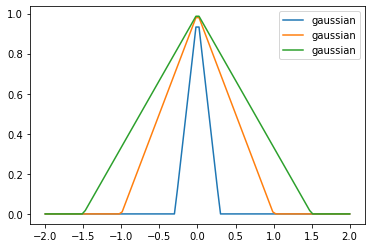

In [49]:
hs = [0.3, 1, 1.5]
xs = np.linspace(-2, 2, 100)

for h in hs:
    win = fixed_window(triangle, h=h)
    ys = win(xs)
    plt.plot(xs, ys, label=name)

plt.legend()

Как мы знаем из семинаров, модель очень чуствительна к выбору ширины окна h. Так как априорных гипотез о его значении у нас нет, перейдем сразу к отбору гиперпараметров.
### Подбор гиперпараметров для PFM
Итак, когда у нас есть некоторый набор ядер, нам остается выбрать оптимальные параметры для нашего классификатора.
А именно:
1. Количество эпох. 
2. Вид ядра
3. Число h

In [50]:
pfm_param_grid = ParameterGrid({
    'epochs': [5, 10, 20],
    'kernel': [rectangle, triangle, quadratic, quartic, gaussian],
    'h': [1e-2, 1e-1, 1, 1e1, 1e2] # постараемся оценить по порядку величины
})

In [51]:
cross_val = KFold(5, shuffle=True)

scores = dict()
for item in tqdm(pfm_param_grid):
    list_of_scores = []
    for train_index, test_index in cross_val.split(X_train):
        
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
          
        scaler = StandardScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_test_fold = scaler.transform(x_test_fold)
        
        kernel = fixed_window(item['kernel'], h=item['h'])
        model = PFM(kernel=kernel)
        model.fit(x_train_fold, y_train_fold, epoch=item['epochs'])
        
        acc = accuracy_score(y_test_fold, model.predict(x_test_fold))
        
        
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

In [52]:
draw_table(scores, title=["ACC"], width=[80, 11])

+--------------------------------------------------------------------------------+-----------+
|                                                                                |        ACC|
+--------------------------------------------------------------------------------+-----------+
|      {'epochs': 5, 'h': 0.01, 'kernel': <function rectangle at 0x7f5235f72830>}|       0.38|
+--------------------------------------------------------------------------------+-----------+
|       {'epochs': 5, 'h': 0.01, 'kernel': <function triangle at 0x7f5235f723b0>}|       0.38|
+--------------------------------------------------------------------------------+-----------+
|      {'epochs': 5, 'h': 0.01, 'kernel': <function quadratic at 0x7f5235f72320>}|       0.38|
+--------------------------------------------------------------------------------+-----------+
|        {'epochs': 5, 'h': 0.01, 'kernel': <function quartic at 0x7f5235f72560>}|       0.38|
+-------------------------------------------------

Выводы по грубому отбору:
1. Количество эпох не сильно влияет на результат, значит алгоритм сходится быстро.
2. При малых h (до 100) алгоритм работает хуже, чем на больших. На малых h только гауссово ядро показывает хороший результат, так как у него нет "обрубания хвостов" по h.
3. Rectangle ядро работает заметно хуже остальных, остальные работают примерно одинково.

Выполним более подробную "подгонку":

In [53]:
pfm_param_grid_2 = ParameterGrid({
    'epochs': [10],
    'kernel': [gaussian], # фиксируем одно из ядер. Выбор не столь принципиален, можно было выбрать любое, кроме rectangle.
    'h': [100, 500, 1000, 2000, 5000]
})

In [54]:
cross_val = KFold(5, shuffle=True)

scores = dict()
for item in tqdm(pfm_param_grid_2):
    list_of_scores = []
    for train_index, test_index in cross_val.split(X_train):
        
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
          
        scaler = StandardScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_test_fold = scaler.transform(x_test_fold)
        
        kernel = fixed_window(item['kernel'], h=item['h'])
        model = PFM(kernel=kernel)
        model.fit(x_train_fold, y_train_fold, epoch=item['epochs'])
        
        acc = accuracy_score(y_test_fold, model.predict(x_test_fold))
        
        
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

In [55]:
draw_table(scores, title=["ACC"], width=[80, 11])

+--------------------------------------------------------------------------------+-----------+
|                                                                                |        ACC|
+--------------------------------------------------------------------------------+-----------+
|       {'epochs': 10, 'h': 100, 'kernel': <function gaussian at 0x7f5235f729e0>}|       0.96|
+--------------------------------------------------------------------------------+-----------+
|       {'epochs': 10, 'h': 500, 'kernel': <function gaussian at 0x7f5235f729e0>}|       0.96|
+--------------------------------------------------------------------------------+-----------+
|      {'epochs': 10, 'h': 1000, 'kernel': <function gaussian at 0x7f5235f729e0>}|       0.96|
+--------------------------------------------------------------------------------+-----------+
|      {'epochs': 10, 'h': 2000, 'kernel': <function gaussian at 0x7f5235f729e0>}|       0.96|
+-------------------------------------------------

Как видно, качество не сильно зависит уже от ширины окна. Наконец, получим итоговую модель.

### Итоговая модель

In [56]:
best_pfm = PFM(kernel=fixed_window(gaussian, h=2000))
best_pfm.fit(X_train_norm, Y_train)

print(classification_report(Y_test, best_pfm.predict(X_test_norm)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.98      1.00      0.99        40

    accuracy                           0.98        57
   macro avg       0.99      0.97      0.98        57
weighted avg       0.98      0.98      0.98        57



# Выводы

Итак, для каждой из трех моделей:
- SVM
- kNN
- PFM

были произведены подбор гиперпараметров, анализ отбора. В каждом случае его по итогам строилась лучшая модель, оценивалось её качество работы на заранее отложенной тестовой выборке.

## Данные
Как и было заявлено в секции "Анализ данных", выборка может быть с хорошей точностью решена изученными методами, что подтверждают полученные результаты. На ней хорошо себя показывают как метрические, так и линейные классификаторы. Однако из-за большого количества признаков и относительно малого количества объектов в ней, для методов с большим количеством параметров необходима регуляризация(см. SVM).

## Модели

Все модели показывают хорошее качество. Однако стоит отметить, что:

- kNN показывает качество заметно хуже, чем оставшиеся, более сложные методы. С одной стороны, предсказания могут разниться от одного значения k к другому, что было показано в подразделе "Итоговая модель". С другой стороны, kNN заметно проще, и никак не учитывает цифру расстояния между объектами. Поэтому и качество оказывается ниже.
- SVM и PFM показывают почти одинаковое качество. Этого можно было ожидать. Ведь PFM по сути есть линейный классификатор, но в качестве признаков берутся значения ядерных функций до объектов, на которых PFM учился. SVM с RBF ядром делает примерно то же самое, разница лишь в подборе весов при соотвествующих объектах. Поэтому и точность предсказаний почти полностью совпадает.


## Замечания

Странно, что в sklearn и прочих популярных библиотеках не нашлось реализации метода потенциальных функций. В остальном проблем с выполнением не возникло.